# Optic Flow Experiment Demo
Inspired by: A Robust Road Vanishing Point Detection Adapted to the
Real-World Driving Scenes

Based on the:
1. analysis
2. stable motion detection
3. stationary point-based motion vector selection
4. angle-based RANSAC
(RANdom SAmple Consensus) voting

In [1]:
RUN_WITH_YOLO_SEG = False

In [2]:
!pip install opencv-python numpy matplotlib ultralytics --quiet

In [3]:
import cv2
import numpy as np
import os
import copy
from matplotlib import pyplot as plt

# create temp folder
if not os.path.exists('temp'):
    os.makedirs('temp')

In [4]:
file = "test_15s_video.MP4"

cap = cv2.VideoCapture(file)
total_number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

file_name = file.split(".")[0]

output_folder = "temp/" + file_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


print(f'Processing file: {file}')
print(f'Total number of frames: {total_number_of_frames}')
print(f'Output folder: {output_folder}')

Processing file: test_15s_video.MP4
Total number of frames: 421
Output folder: temp/test_15s_video


### Frame handling

In [5]:
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    if not success:
        raise ValueError(f"Failed to read frame at position {frame_number}")
    
    # frame = cv2.resize(frame, (640, 480))
    processed_frame = preprocess_frame(frame)
    return frame, processed_frame

# Video Builder

In [6]:
class VideoBuilder:
    def __init__(self, filename, fps):
        self.fps = fps
        self.output_file = filename
        self.recorder = None

    def add_frame(self, frame):
        if self.recorder is None:
            self.recorder = cv2.VideoWriter(self.output_file, cv2.VideoWriter_fourcc(*'XVID'), self.fps, (frame.shape[1], frame.shape[0]))

        self.recorder.write(frame)

    def stop_recording(self):
        if self.recorder is not None:
            self.recorder.release()
            self.recorder = None


# Yolo Segmentation Mask

In [7]:
from ultralytics import YOLO

# segmentation model
model = YOLO("yolo11m-seg.pt")  # load a pretrained model (recommended for inference)

def get_vehicle_mask(_frame):
    # run the model on the frame
    results = model([_frame], verbose=False)

    # get the first result (the only one in this case)
    if len(results) == 0:
        print("No results found.")
        return np.ones((_frame.shape[0], _frame.shape[1]), dtype=np.uint8)
    
    result = results[0]
    # result.save(filename="result.jpg")

    if result.masks is None or result.boxes is None:
        print("No masks or boxes found.")
        return np.ones((_frame.shape[0], _frame.shape[1]), dtype=np.uint8)
    
    masks = result.masks.data.cpu().numpy()  
    class_ids = result.boxes.cls.cpu().numpy().astype(int)

    vehicle_classes = {"car", "truck", "bus", "motorcycle", "bicycle"}
    _mask = np.zeros((_frame.shape[0], _frame.shape[1]), dtype=np.uint8)

    for i, class_id in enumerate(class_ids):
        class_name = model.names[class_id]
        if class_name in vehicle_classes:
            resized_mask = cv2.resize(
                masks[i].astype(np.uint8),
                (_frame.shape[1], _frame.shape[0]),  # (width, height)
                interpolation=cv2.INTER_NEAREST
            )
            _mask = np.logical_or(_mask, resized_mask).astype(np.uint8)

    vehicle_mask = _mask.astype(np.uint8)  # 0 or 1

    return vehicle_mask


# frame = get_frame(cap, 0)[0]

# # get the vehicle mask
# vehicle_seg_mask = get_vehicle_mask(frame)

# plt.imshow(vehicle_seg_mask, cmap='gray')

In [8]:
def is_point_on_vehicle(point, mask):
    x, y = int(point[0]), int(point[1])
    if x < 0 or y < 0 or x >= mask.shape[1] or y >= mask.shape[0]:
        return False
    return mask[y, x] == 1

# Motion Vector Detection

initialise motion detection parameters

In [9]:
# params for Shi-Tomasi corner detection
feature_params = dict( maxCorners = 40, # 50 for non grid based
                       qualityLevel = 0.3,
                       minDistance = 20,
                       blockSize = 7,)

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# minimum displacement
MINIMUM_TRACKED_POINTS = 400
MINIMUM_DISPLACEMENT = 1
MAXIMUM_TRAJECTORY_LENGTH = 50

# R-VP parameters
THRESHOLD_REMOVE_SHORT_TRAJECTORIES = 40

corner detection mask to select new points from a distance (Region of interest)

(np.float64(-0.5), np.float64(2559.5), np.float64(1439.5), np.float64(-0.5))

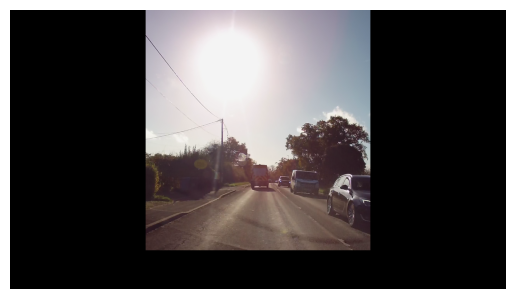

In [10]:
frame, _ = get_frame(cap, 0)

frame_height, frame_width = frame.shape[:2]
mask = np.ones((frame_height, frame_width), dtype=np.uint8)

# apply mask to select new points from a distance (Region of interest)
mask[-200:] = 0
mask[:, :700] = 0
mask[:, -700:] = 0

masked_bgr = cv2.bitwise_and(frame, frame, mask=mask)
masked_bgr = cv2.cvtColor(masked_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(masked_bgr)
plt.axis('off')

### Corner Feature Detection
Detect corners using Shi-Tomasi corner detection algorithm.

In [11]:
# all_corners = []

# corner_cache = {} # cache to optimise when tweaking parameters

# def get_points_of_frame(frame_number):
#     if frame_number in corner_cache:
#         return corner_cache.get(frame_number)
    
#     _, frame = get_frame(cap, frame_number) # using processed frame, not original

#     # shi-tomasi corner detection
#     corners = cv2.goodFeaturesToTrack(frame, mask = mask, **feature_params)

#     if corners is None:
#         print(f"No corners found in frame {frame_number}.")
#         return None

#     corner_cache[frame_number] = corners
#     return corners

def split_into_grid(frame, grid_size):
    height, width = frame.shape
    grid_height, grid_width = grid_size
    grid_height = height // grid_height
    grid_width = width // grid_width

    grid = []
    for i in range(0, height, grid_height):
        for j in range(0, width, grid_width):
            grid.append(
                [i,j,frame[i:i+grid_height, j:j+grid_width]]
            )

    return grid

def get_points_of_frame(frame_number):
    _, frame = get_frame(cap, frame_number) # using processed frame, not original
    frame = cv2.bitwise_and(frame, frame, mask=mask)

    grid = split_into_grid(frame, (4, 4))

    corner_list = []

    for g in grid:
        # shi-tomasi corner detection
        new_corners = cv2.goodFeaturesToTrack(g[2], **feature_params)
        if new_corners is None:
            continue
        
        for corner in new_corners:
            corner[0][0] += g[1]
            corner[0][1] += g[0]
            corner_list.append(corner[0])

    corner_list = np.array(corner_list, dtype=np.float32)
    corner_list = corner_list.reshape(-1, 1, 2)

    return corner_list


Example frame 0 with 167 corners


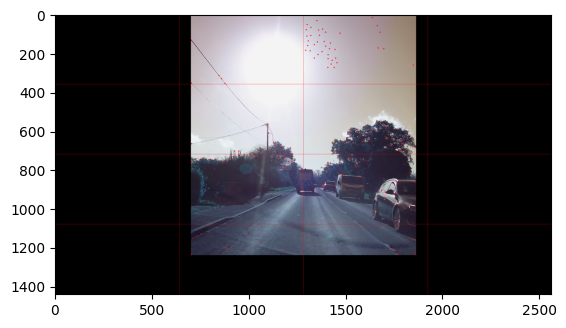

In [12]:
frame = get_frame(cap, 0)[0]
corners = get_points_of_frame(0)

print(f'Example frame {0} with {len(corners)} corners')

frame = cv2.bitwise_and(frame, frame, mask=mask)

for corner in corners:
    x, y = corner[0]
    cv2.circle(frame, (int(x), int(y)), 3, 255, -1)

# draw (8,8) grid
for i in range(0, frame.shape[0], frame.shape[0]//4):
    cv2.line(frame, (0, i), (frame.shape[1], i), 255, 1)

for i in range(0, frame.shape[1], frame.shape[1]//4):
    cv2.line(frame, (i, 0), (i, frame.shape[0]), 255, 1)
    
plt.imshow(frame)

### Feature Tracking using Lucas-Kanade Optical Flow

#### Output video of the motion vectors

In [13]:
# random colours to label different lines
color = np.random.randint(0, 255, (400000, 3))

def get_frame_with_trajectories(frame_number, trajectories):
    original_frame, _ = get_frame(cap, frame_number)

    original_frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

    if RUN_WITH_YOLO_SEG:
        # Draw the mask on the original frame with 50% opacity
        vehicle_mask = get_vehicle_mask(original_frame)  # values 0 or 1
        colored_mask = np.zeros_like(original_frame)
        colored_mask[vehicle_mask == 1] = (0, 0, 255)  
        original_frame = cv2.addWeighted(original_frame, 1.0, colored_mask, 0.5, 0)
    
    # Draw the full trajectories
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color) # Get a consistent color based on start position
        for j in range(1, len(points)): # Draw a line between all consecutive points
            a, b = points[j]
            c, d = points[j - 1]
            original_frame = cv2.line(original_frame, (int(a), int(b)), (int(c), int(d)), color[color_idx].tolist(), 2)

    # Draw current points as circles
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color) # Get a consistent color based on start position
        a, b = points[-1] # draw the last point
        original_frame = cv2.circle(original_frame, (int(a), int(b)), 5, color[color_idx].tolist(), -1)

    return original_frame


# create frames with trajectories and save them to a video
def output_video_of_trajectories(frame_trajectories, filename):
    video = VideoBuilder(filename, 30)
    for i in range(total_number_of_frames):
        frame_number = i
        trajectories = frame_trajectories[i]
        frame = get_frame_with_trajectories(frame_number, trajectories)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video.add_frame(frame)
    video.stop_recording()

#### Remove stationary points
Filter and remove points that are not moving more than Min_displacement

In [14]:
def filter_for_minimum_displacement(good_old, good_new):
    """
    Filter out points that have not moved significantly.

    Args:
        good_old: old features from good matches
        good_new: new features from good matches

    Returns:
        list: filtered good_old and good_new points
    """
    new_good_old = []
    new_good_new = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        new_x, new_y = new.ravel()
        old_x, old_y = old.ravel()
        if abs(new_x - old_x) > MINIMUM_DISPLACEMENT or abs(new_y - old_y) > MINIMUM_DISPLACEMENT:
            new_good_old.append(old)
            new_good_new.append(new)
    return np.array(new_good_old), np.array(new_good_new)

#### Clip max trajectory length
Hard limit length of a tracked point

In [15]:
def clip_max_trajectory(trajectory_list):
    """
    Clip the trajectory list to the maximum length.

    Args:
        trajectory_list (list): list of trajectory records

    Returns:
        list: clipped trajectory list
    """
    return trajectory_list[-MAXIMUM_TRAJECTORY_LENGTH:]

Check if trajectories moving towards edge of the image

In [16]:
def remove_trajectories_not_diverging_from_center_x_axis(trajectories, center_x):
    """
    Remove trajectories that are not diverging from the center.

    Args:
        trajectories (dict): dictionary of trajectories

    Returns:
        dict: filtered trajectories
    """
    filtered_trajectories = {}
    for start_position, points in trajectories.items():
        if len(points) > 1:
            # Calculate the distance from the first point to the last point
            # print(f"Trajectory {start_position}: {points}")
            x_diff = points[-1][0] - points[0][0]

            center_x_diff = points[-1][0] - center_x

            # Check if the trajectory is diverging from the center
            if (x_diff< 0 and center_x_diff < 0) or (x_diff > 0 and center_x_diff > 0):
                filtered_trajectories[start_position] = points
    return filtered_trajectories

#### Perform tracking
- Points over many consecutive frames are considered stable motion vectors

In [17]:
def get_all_frame_trajectories():
    all_frame_trajectories = [] # store all trajectories for each frame

    # initial frame and starting points
    p0 = get_points_of_frame(0)
    _, last_frame = get_frame(cap, 0)

    # Init tracked points
    trajectories = {tuple(p.ravel()): [p.ravel()] for p in p0}

    # Store initial trajectories
    all_frame_trajectories.append(copy.deepcopy(trajectories))

    # for each frame at an increment of 1
    for i in range(1, total_number_of_frames):
        colour_frame , frame_gray = get_frame(cap, i)
        
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(last_frame, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]

        # Filter out points that have not moved above a given threshold
        good_old, good_new = filter_for_minimum_displacement(good_old, good_new)

        # get a tracked point using the last tracked position as the key
        new_trajectories = {}


        for new, old in zip(good_new, good_old):
            start_position = tuple(old.ravel())  # Use the original position as the key
            next_iterations_start_position = tuple(new.ravel())  # Use the new position as the key for the next iteration

            # Check if the new point is on a vehicle in the mask
            if start_position in trajectories:
                # Update tracked points with new position
                trajectories[start_position].append(tuple(new.ravel()))
                # create a new set of trajectories with the new position as the key
                new_trajectories[next_iterations_start_position] = clip_max_trajectory(trajectories[start_position])

        # Replace old trajectories with updated ones that exclude lost points
        trajectories = new_trajectories

        # remove trajectories that are not diverging from the center
        center_x = frame_gray.shape[1] // 2
        trajectories = remove_trajectories_not_diverging_from_center_x_axis(trajectories, center_x)

        if RUN_WITH_YOLO_SEG:
            vehicle_mask = get_vehicle_mask(colour_frame)
            filtered = {}
            for start, pts in trajectories.items():
                last_pt = pts[-1]
                if not is_point_on_vehicle(last_pt, vehicle_mask):
                    filtered[start] = pts
            trajectories = filtered


        # make a record of the trajectories at frame i
        all_frame_trajectories.append(copy.deepcopy(trajectories))

        # prepare for next iteration
        last_frame = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        # keep adding points once fall below a minimum threshold
        if len(p0) < MINIMUM_TRACKED_POINTS:
            new_points = get_points_of_frame(i)
            p0 = np.concatenate((p0, new_points), axis=0)
            # add new points to next tracked trajectories
            for new_p in new_points:
                start_position = tuple(new_p.ravel())
                if start_position not in trajectories:
                    trajectories[start_position] = [tuple(new_p.ravel())]
    
    return all_frame_trajectories

all_frame_trajectories = get_all_frame_trajectories()

#### Display tracked points counts by frame

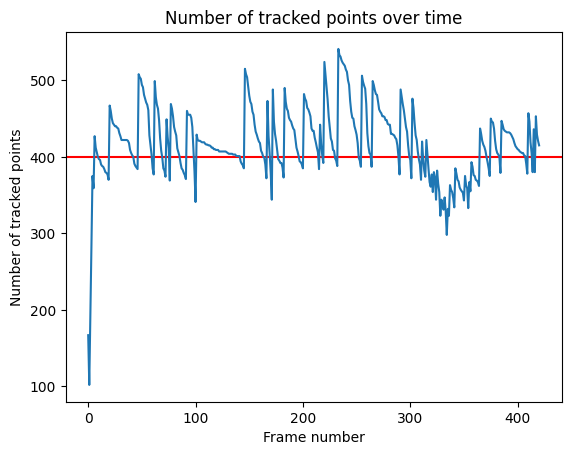

In [18]:
x = np.arange(0, total_number_of_frames)
y = [len(frame_trajectories) for frame_trajectories in all_frame_trajectories]

plt.axhline(y=MINIMUM_TRACKED_POINTS, color='r', linestyle='-')
plt.title('Number of tracked points over time')
plt.xlabel('Frame number')
plt.ylabel('Number of tracked points')
plt.plot(x, y)

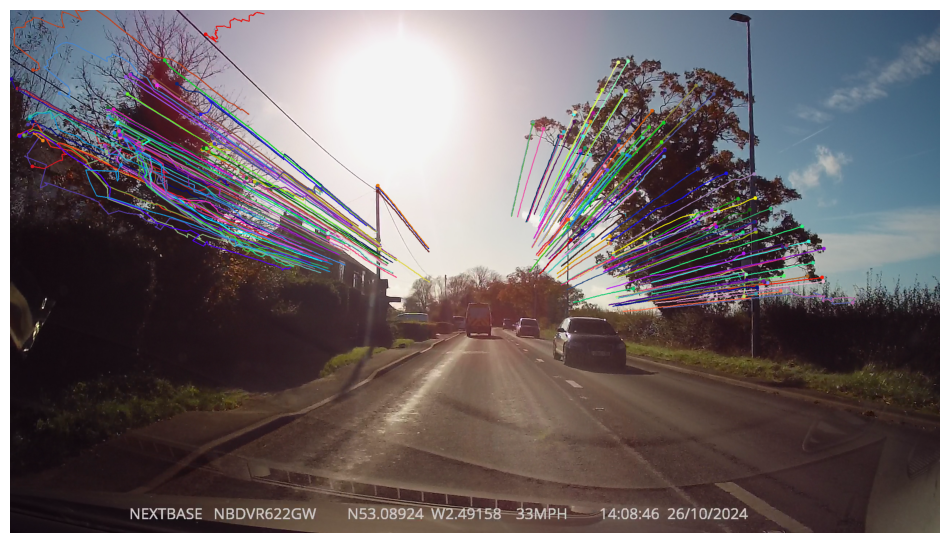

In [19]:
example_frame = 280

# filter related frame for short trajectories
trajectories = all_frame_trajectories[example_frame]
ignore_short_history_trajectories = {start_position: points for start_position, points in trajectories.items() if len(points) > THRESHOLD_REMOVE_SHORT_TRAJECTORIES}

# display frame with trajectories
frame = get_frame_with_trajectories(example_frame, ignore_short_history_trajectories)
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(frame)

#### Output video of all unprocessed trajectories

In [20]:
print(f'Outputting video with trajectories to {output_folder}/all_trajectories.avi')
output_video_of_trajectories(all_frame_trajectories, f'{output_folder}/all_trajectories.avi')

Outputting video with trajectories to temp/test_15s_video/all_trajectories.avi


KeyboardInterrupt: 

# Choosing stationary object motion vectors

Remove vector paths with low momentum

# R-VP Voting
Using RANSAC to find the best vanishing point

#### RANSAC voting

In [21]:
import numpy as np

def find_vanishing_point(line_segments, iterations=500, threshold=10,  inlier_ratio=0.6):
    best_vanishing_point = None
    max_inliers = 0
    total_segments = len(line_segments)
    
    # pre-solve slopes and intercepts
    slopes = []
    intercepts = []
    for (start, end) in line_segments:
        x1, y1 = start
        x2, y2 = end
        if x2 != x1:  # Non-vertical line
            m = (y2 - y1) / (x2 - x1)
            c = y1 - m * x1
        else:  # Vertical line case, set slope to None
            m, c = None, x1
        slopes.append(m)
        intercepts.append(c)
    
    slopes = np.array(slopes)
    intercepts = np.array(intercepts)
    
    for _ in range(iterations):
        # Randomly select two line segments
        idx1, idx2 = np.random.choice(total_segments, 2, replace=False)
        
        m1, c1 = slopes[idx1], intercepts[idx1]
        m2, c2 = slopes[idx2], intercepts[idx2]
        
        # Skip if parallel or identical (no unique intersection)
        if m1 == m2:
            continue
        
        # Calculate intersection point
        if m1 is not None and m2 is not None:
            # Both lines are non-vertical
            x_intersect = (c2 - c1) / (m1 - m2)
            y_intersect = m1 * x_intersect + c1
        elif m1 is None:  # Line 1 is vertical
            x_intersect = c1
            y_intersect = m2 * x_intersect + c2
        elif m2 is None:  # Line 2 is vertical
            x_intersect = c2
            y_intersect = m1 * x_intersect + c1
        
        intersection_point = np.array([x_intersect, y_intersect])
        
        # Calculate distances for all line segments to this intersection point
        distances = []
        for i, (m, c) in enumerate(zip(slopes, intercepts)):
            if m is not None:
                # Non-vertical line: calculate perpendicular distance
                y_hat = m * x_intersect + c
                distance = abs(y_hat - y_intersect)
            else:
                # Vertical line: distance is horizontal distance
                distance = abs(x_intersect - c)
            distances.append(distance)
        
        distances = np.array(distances)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)
        
        # Update best vanishing point if this one has more inliers
        if num_inliers > max_inliers:
            best_vanishing_point = intersection_point
            max_inliers = num_inliers
            
            # Early stopping if enough inliers found
            if max_inliers / total_segments >= inlier_ratio:
                break
    
    return best_vanishing_point, max_inliers

In [22]:
ransac_vectors = []

for start_position, points in ignore_short_history_trajectories.items():
    for i in range(1, len(points)):
        # Store both start and end points of each vector
        start_point = points[i - 1]
        end_point = points[i]
        ransac_vectors.append([start_point, end_point])

ransac_vectors = np.array(ransac_vectors)

vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)
print("Vanishing Point:", vanishing_point)
print("Number of Inliers:", inliers_count)

Vanishing Point: [     1314.1      855.21]
Number of Inliers: 2617


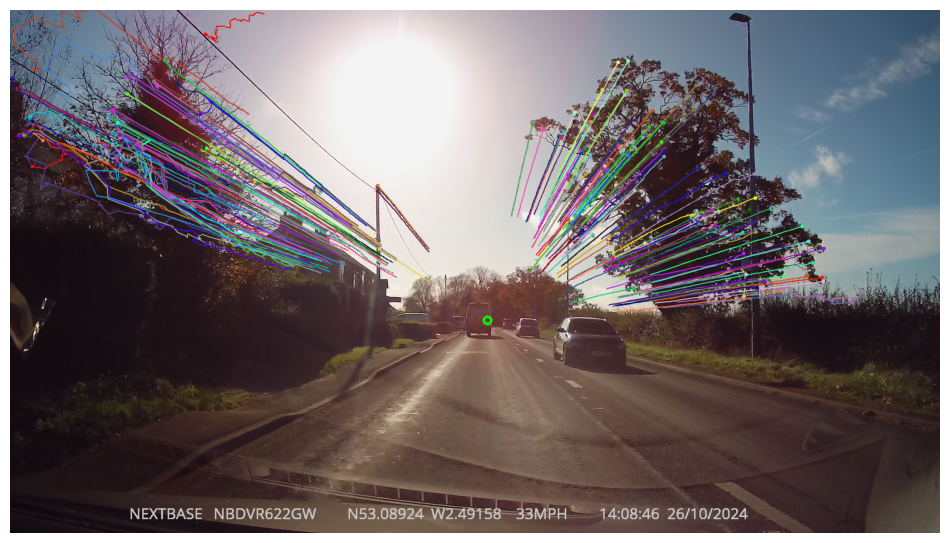

In [23]:
frame = get_frame_with_trajectories(example_frame, ignore_short_history_trajectories)

# Draw vp
if vanishing_point is not None:
    frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 6)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(frame)

#### Find R-VP using RANSAC on all frames
Run R-VP voting on all frames and add the best vanishing point to all_vp

In [ ]:
print ("Processing all frames for vanishing points")
all_vp = []

for i in range(total_number_of_frames):
    trajectories = all_frame_trajectories[i]
    ignore_short_history_trajectories = {start_position: points for start_position, points in trajectories.items() if len(points) > THRESHOLD_REMOVE_SHORT_TRAJECTORIES}
    ransac_vectors = []

    for start_position, points in ignore_short_history_trajectories.items():
        for i in range(1, len(points)):
            start_point = points[i - 1]
            end_point = points[i]
            ransac_vectors.append([start_point, end_point])

    ransac_vectors = np.array(ransac_vectors)

    if len(ransac_vectors) < 2:
        all_vp.append(np.array([0, 0]))
        continue
    vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)
    all_vp.append(vanishing_point)

all_vp = np.array(all_vp)

Processing all frames for vanishing points


KeyboardInterrupt: 

In [ ]:
def output_video_of_R_VP(VP, filename):
    video = VideoBuilder(filename, 30)
    for i in range(0, len(VP)):
        frame_number = i
        vanishing_point = VP[i]
        frame = get_frame_with_trajectories(frame_number, all_frame_trajectories[frame_number])
        if vanishing_point is not None:
            frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 5)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video.add_frame(frame)
    video.stop_recording()

print(f'Outputting video with vanishing points to {output_folder}/all_vp.avi')
output_video_of_R_VP(all_vp, f'{output_folder}/all_vp.avi')

Outputting video with vanishing points to temp/test_15s_video/all_vp.avi
No masks or boxes found.
